In [1]:
import os
import monai

import torch
#from lib.transforms.transforms import NormalizeLabelsInDatasetd
#from monai.apps.deepedit.interaction import Interaction
#from monai.apps.deepedit.transforms import (
#    AddGuidanceSignalDeepEditd,
#    AddInitialSeedPointMissingLabelsd,
#    AddRandomGuidanceDeepEditd,
#    FindAllValidSlicesMissingLabelsd,
#    FindDiscrepancyRegionsDeepEditd,
#    SplitPredsLabeld,
#)
import numpy as np
from monai.handlers import MeanDice, from_engine
from monai.inferers import SlidingWindowInferer
from monai.losses import DiceCELoss
from monai.transforms import (
    Compose,
    Activationsd,
    AsDiscreted,
    EnsureChannelFirstd,
    EnsureTyped,
    LoadImaged,
    Orientationd,
    RandShiftIntensityd,
    RandFlipd,
    RandRotate90d,
    RandShiftIntensityd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    CropForegroundd,
    Spacingd,
    ToTensord,
    NormalizeIntensityd,
    ScaleIntensityd
)
import matplotlib.pyplot as plt

In [2]:
train_transforms_normalizeintensity = Compose([
    LoadImaged(keys=["image", "label"], ensure_channel_first=False),
    EnsureChannelFirstd(keys=["image", "label"]),
    NormalizeIntensityd(keys="image", nonzero=True), # <- ajout
    CropForegroundd(keys=["image", "label"], source_key="image"),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    Spacingd(
        keys=["image", "label"],
        pixdim=(1, 1, 1),
        mode=("bilinear", "nearest")),
    ScaleIntensityd(keys="image", minv=-1.0, maxv=1.0), # <- ajout
    RandCropByPosNegLabeld(
        keys=["image", "label"],
        label_key="label",
        spatial_size=(96, 96, 96),
        pos=1,
        neg=1,
        num_samples=4,
        image_key="image",
        image_threshold=0),
    RandFlipd(
        keys=["image", "label"],
        spatial_axis=[0],
        prob=0.10),
    RandFlipd(
        keys=["image", "label"],
        spatial_axis=[1],
        prob=0.10),
    RandFlipd(
        keys=["image", "label"],
        spatial_axis=[2],
        prob=0.10),
    RandRotate90d(
        keys=["image", "label"],
        prob=0.10,
        max_k=3),
    RandShiftIntensityd(
        keys=["image"],
        offsets=0.10,
        prob=0.50)
        ])

train_transforms_scaleintensityranged = Compose([
    LoadImaged(keys=["image", "label"], ensure_channel_first=False),
           EnsureChannelFirstd(keys=["image", "label"]),
           ScaleIntensityRanged(
            keys="image", 
            a_min=-15,
            a_max=100, 
            b_min=-1.0, 
            b_max=1.0, 
            clip=True),
            CropForegroundd(keys=["image", "label"], source_key="image"),
            Orientationd(keys=["image", "label"], axcodes="RAS"),
            Spacingd(
                keys=["image", "label"],
                pixdim=(1, 1, 1),
                mode=("bilinear", "nearest"),
                ),
    RandCropByPosNegLabeld(
        keys=["image", "label"],
        label_key="label",
        spatial_size=(96, 96, 96),
        pos=1,
        neg=1,
        num_samples=4,
        image_key="image",
        image_threshold=0),
    RandFlipd(
        keys=["image", "label"],
        spatial_axis=[0],
        prob=0.10),
    RandFlipd(
        keys=["image", "label"],
        spatial_axis=[1],
        prob=0.10),
    RandFlipd(
        keys=["image", "label"],
        spatial_axis=[2],
        prob=0.10),
    RandRotate90d(
        keys=["image", "label"],
        prob=0.10,
        max_k=3),
    RandShiftIntensityd(
        keys=["image"],
        offsets=0.10,
        prob=0.50)
        ])

monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.


In [3]:
dataset_folder = "/home/fehrdelt/data_ssd/2024_Projet_Anais/Clinical_database/"
train_set_folder = "fixed_distribution/train_dataset/"

In [4]:
transformed_img_label_pairs = []

for file in os.listdir(dataset_folder+train_set_folder):
    if file.endswith("nii.gz"):
        
        data = {"image":dataset_folder+train_set_folder+file,"label":dataset_folder+train_set_folder+"labels/final/"+file}
        transformed = train_transforms_normalizeintensity(data)
        
        transformed_img_label_pairs.append({"image":transformed[0]["image"][0,:,:,48], "label":transformed[0]["label"][0,:,:,48]})
        
rows = int(np.ceil(np.sqrt(len(transformed_img_label_pairs)*2)))


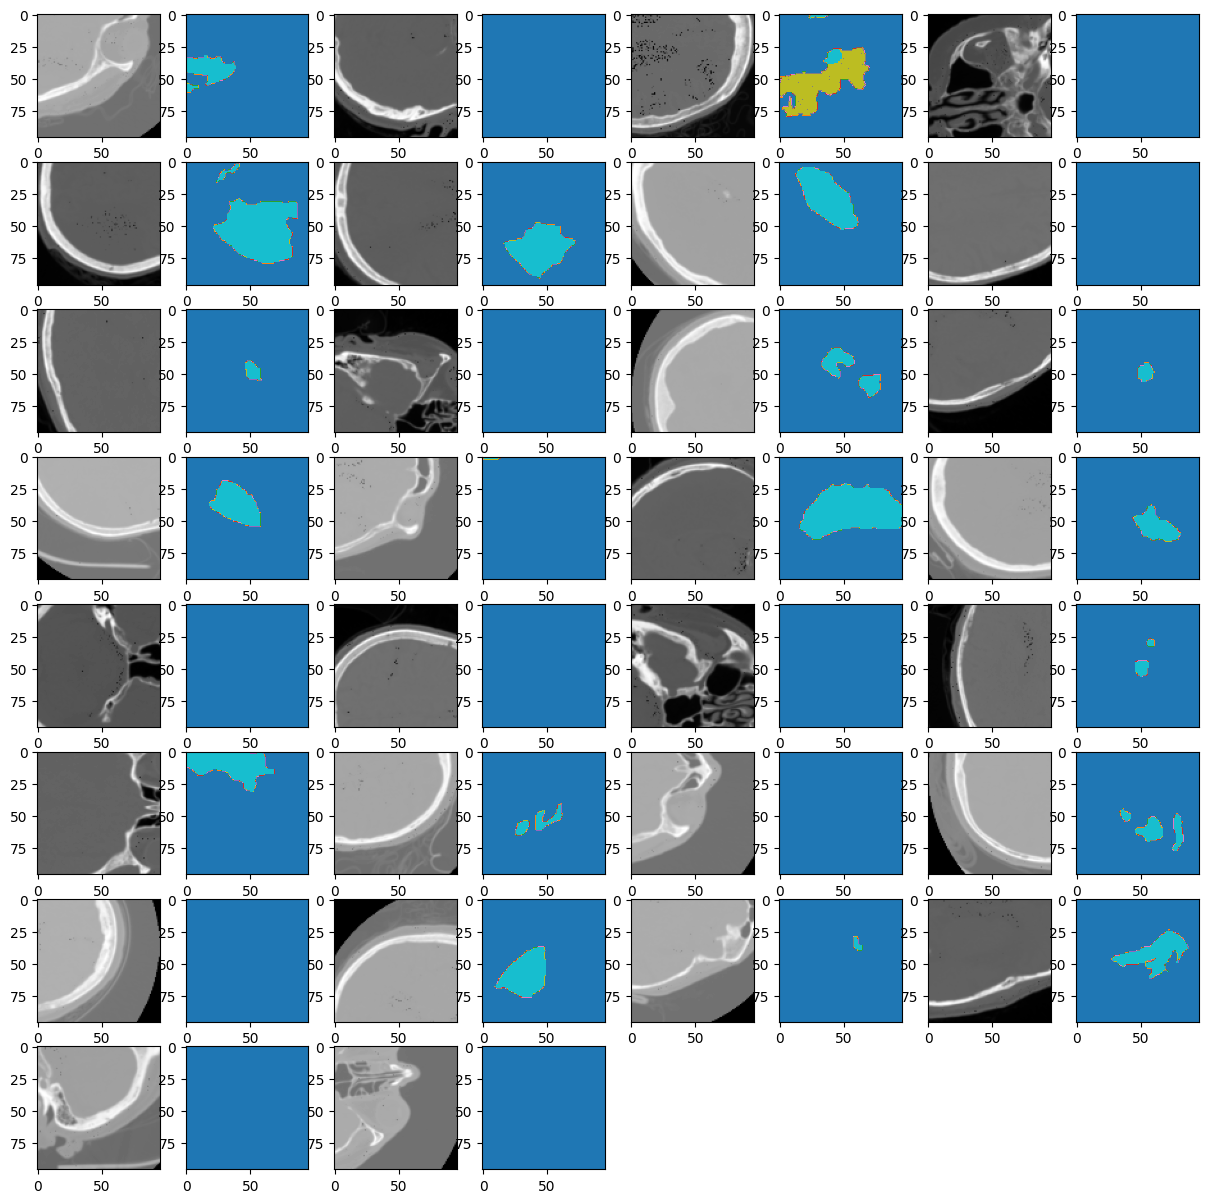

In [5]:

plt.figure(figsize=(15,15))


for i,pair in enumerate(transformed_img_label_pairs):
    plt.subplot(rows, rows, 1+i*2)
    plt.imshow(pair["image"], cmap="gray")
    plt.subplot(rows, rows, 1+i*2+1)
    plt.imshow(pair["label"], cmap="tab10")

In [6]:
transformed_img_label_pairs = []

for file in os.listdir(dataset_folder+train_set_folder):
    if file.endswith("nii.gz"):
        
        data = {"image":dataset_folder+train_set_folder+file,"label":dataset_folder+train_set_folder+"labels/final/"+file}
        transformed = train_transforms_scaleintensityranged(data)
        
        transformed_img_label_pairs.append({"image":transformed[0]["image"][0,:,:,48], "label":transformed[0]["label"][0,:,:,48]})
        
rows = int(np.ceil(np.sqrt(len(transformed_img_label_pairs)*2)))


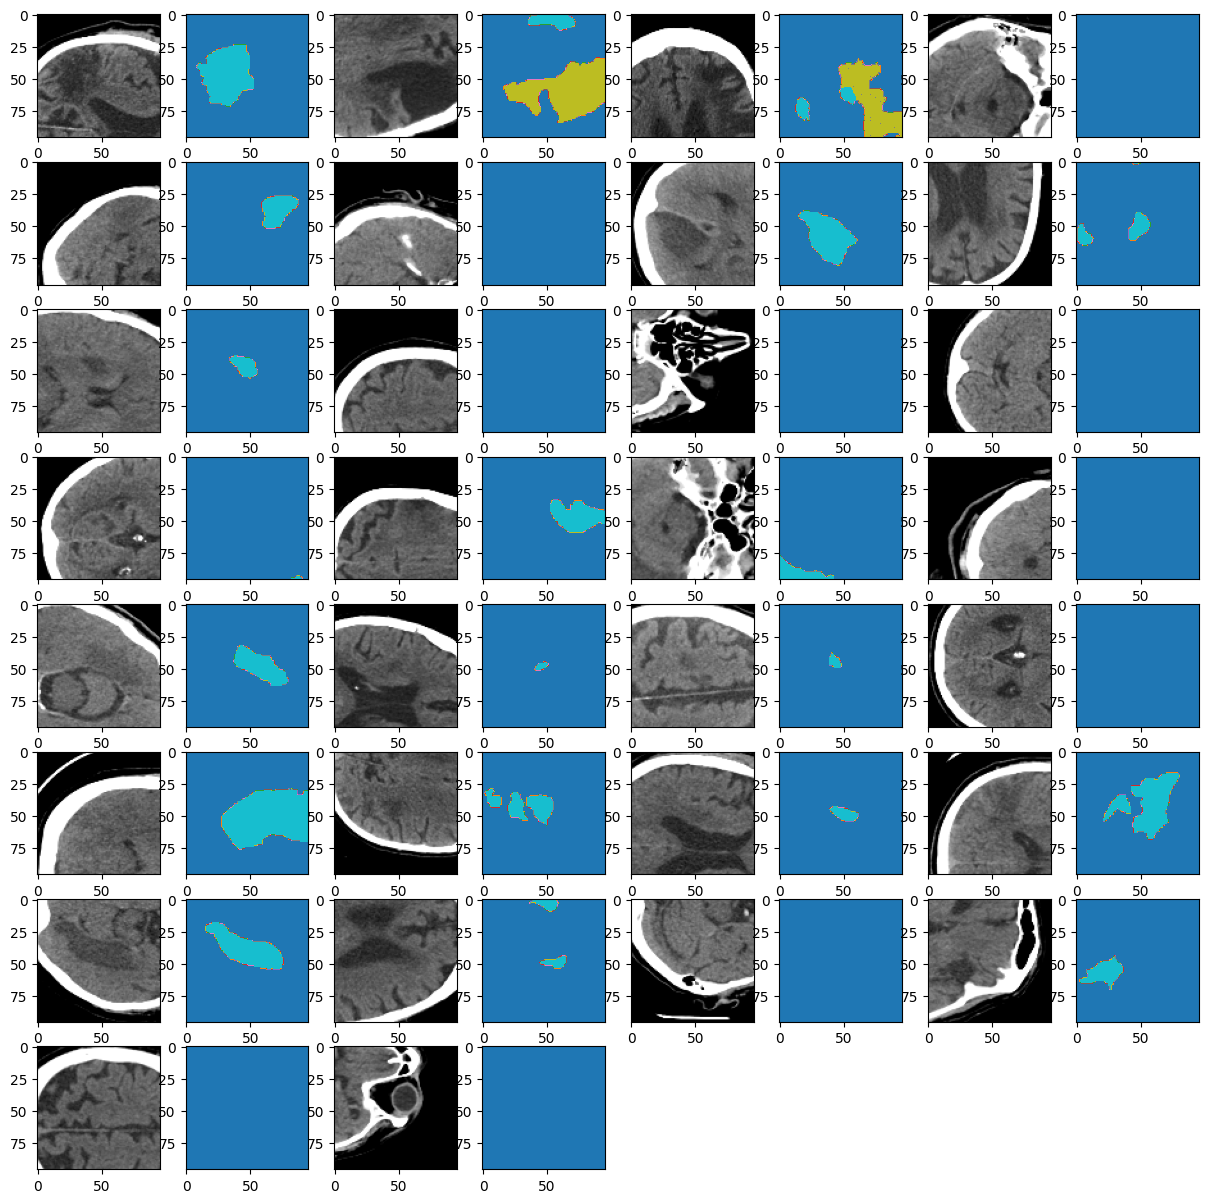

In [7]:

plt.figure(figsize=(15,15))


for i,pair in enumerate(transformed_img_label_pairs):
    plt.subplot(rows, rows, 1+i*2)
    plt.imshow(pair["image"], cmap="gray")
    plt.subplot(rows, rows, 1+i*2+1)
    plt.imshow(pair["label"], cmap="tab10")